<a href="https://colab.research.google.com/github/Abdul-Waahab/test/blob/main/abw_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)


**Load Dataset**

In [15]:

df = pd.read_csv("Cybersecurity Intrusion Detection.csv")
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)


Dataset shape: (9537, 11)

Data types:
 session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object


**EDA: Missing Values & Class Distribution**


Missing Values:
 session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


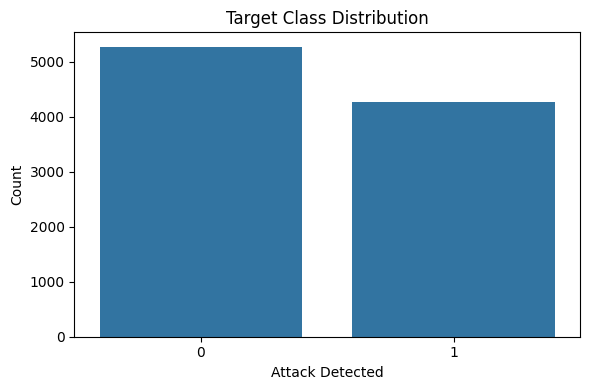

In [16]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Class balance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='attack_detected')
plt.title('Target Class Distribution')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**EDA: Pie Chart of Browser Types**

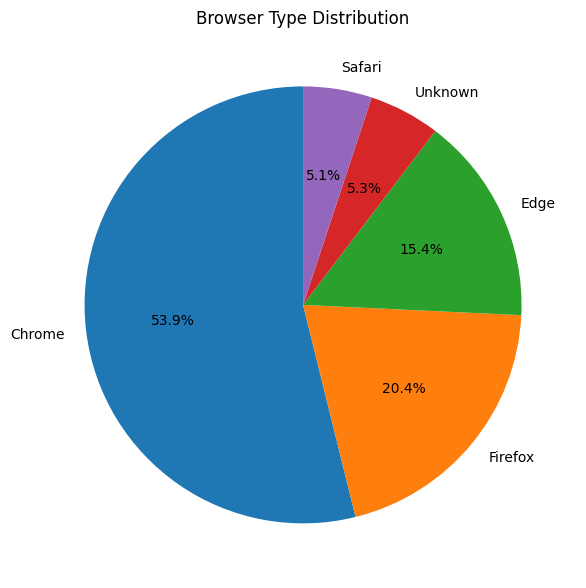

In [17]:
plt.figure(figsize=(6, 6))
df['browser_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Browser Type Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()


**Correlation Matrix Fix**

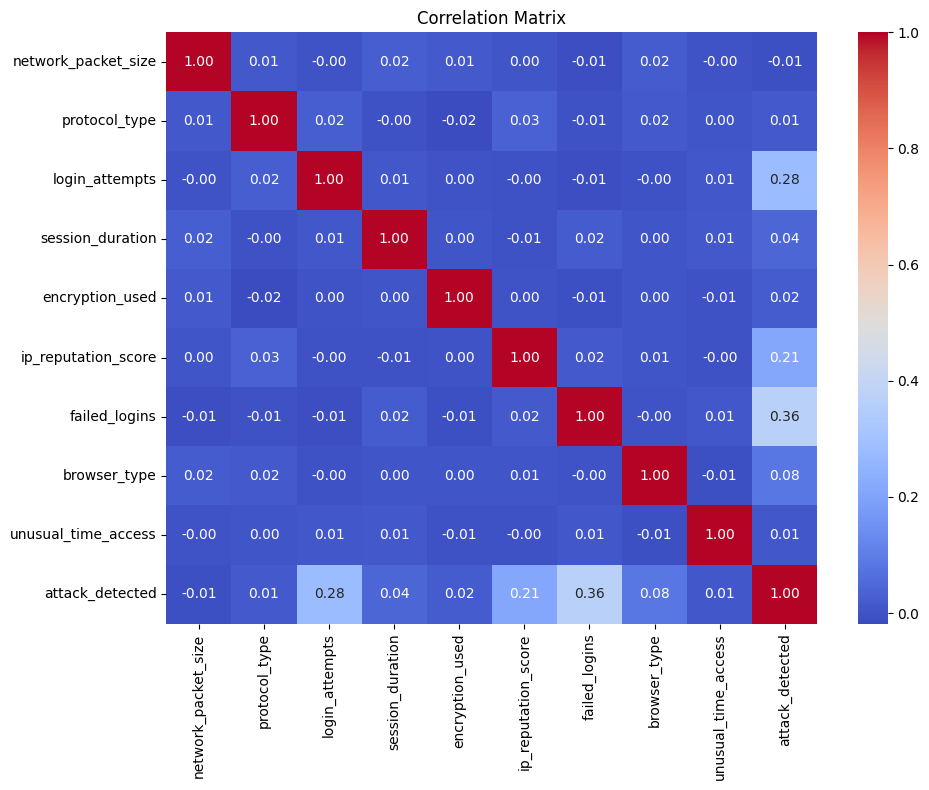

In [18]:
# Drop non-numeric and fill missing values
df.drop(columns=['session_id'], inplace=True)
df['encryption_used'].fillna('Unknown', inplace=True)

# Label encode categoricals
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']
df_encoded = df.copy()
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


**Preprocessing (Encoding, Scaling)**

In [19]:
# Encode original df now
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

X = df.drop("attack_detected", axis=1)
y = df["attack_detected"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


Feature matrix shape: (9537, 9)


**Train-Test Split**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 7629 Test size: 1908


**Model Training**

In [21]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "confusion": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred,
        "y_proba": y_proba
    }

    print(f"\n{name} Metrics:")
    print("Accuracy:", results[name]["accuracy"])
    print("Precision:", results[name]["precision"])
    print("Recall:", results[name]["recall"])
    print("F1 Score:", results[name]["f1"])
    print("ROC AUC:", results[name]["roc_auc"])



Random Forest Metrics:
Accuracy: 0.8836477987421384
Precision: 0.9921996879875195
Recall: 0.7456037514654161
F1 Score: 0.8514056224899599
ROC AUC: 0.8729474450364757

XGBoost Metrics:
Accuracy: 0.8794549266247379
Precision: 0.9712556732223904
Recall: 0.7526377491207503
F1 Score: 0.8480845442536328
ROC AUC: 0.8757938249723586

Logistic Regression Metrics:
Accuracy: 0.7285115303983228
Precision: 0.7128335451080051
Recall: 0.6576787807737398
F1 Score: 0.6841463414634147
ROC AUC: 0.7799625520188017


**Metrics Comparison Bar Plot**

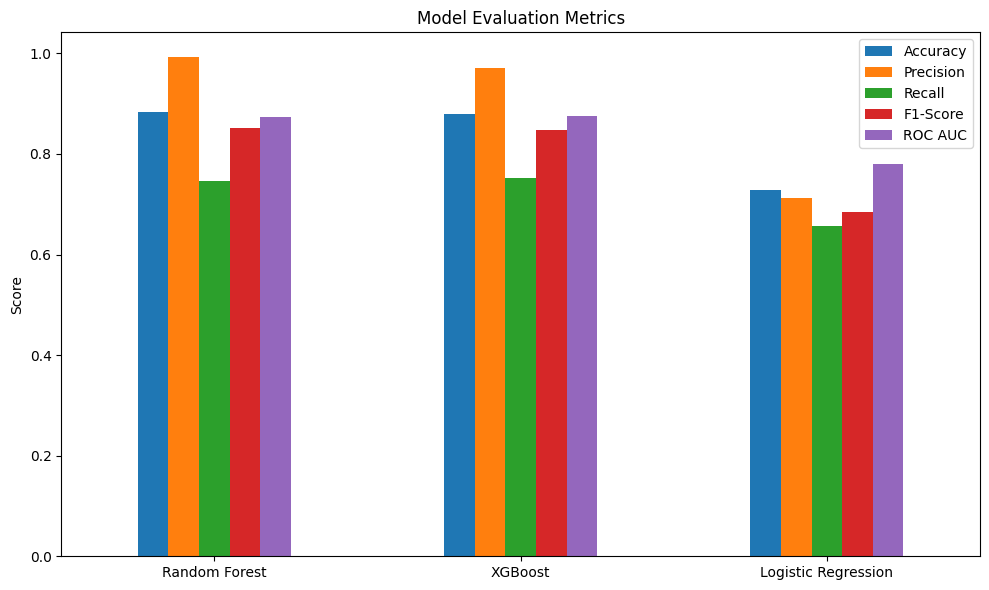

In [22]:
metrics_df = pd.DataFrame({model: {
    "Accuracy": vals["accuracy"],
    "Precision": vals["precision"],
    "Recall": vals["recall"],
    "F1-Score": vals["f1"],
    "ROC AUC": vals["roc_auc"]
} for model, vals in results.items()}).T

metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Confusion Matrix Plots**

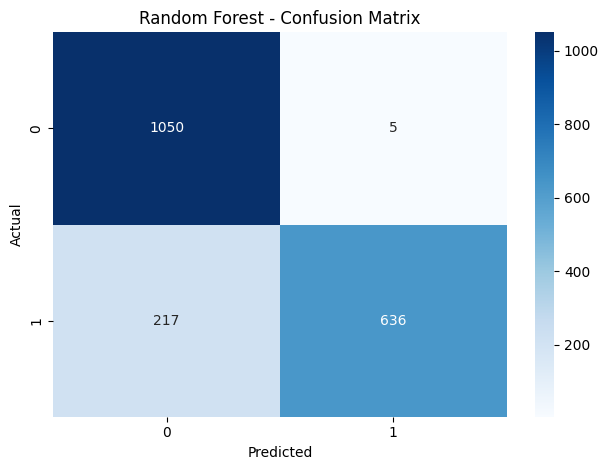

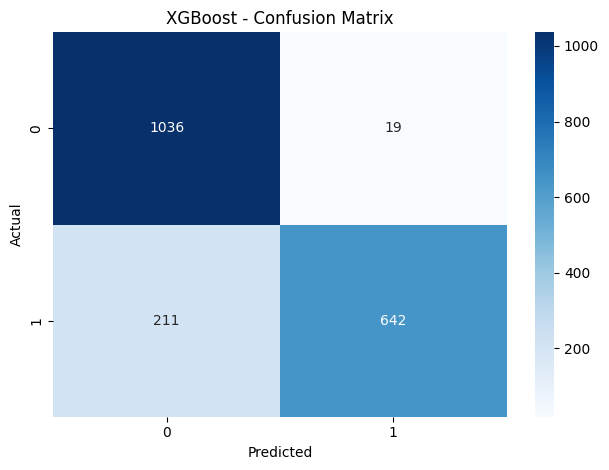

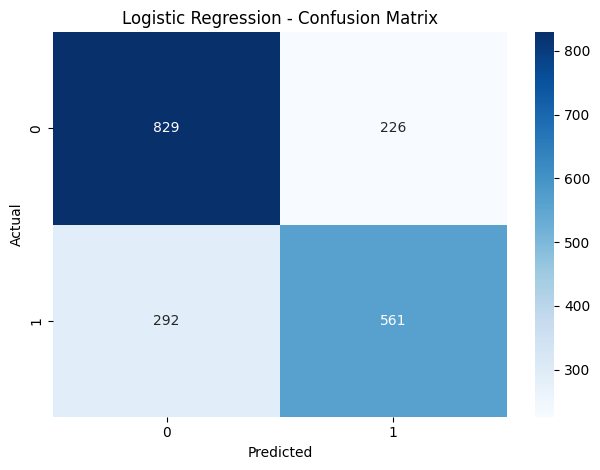

In [23]:
for model in results:
    cm = results[model]["confusion"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


**ROC Curve Comparison**

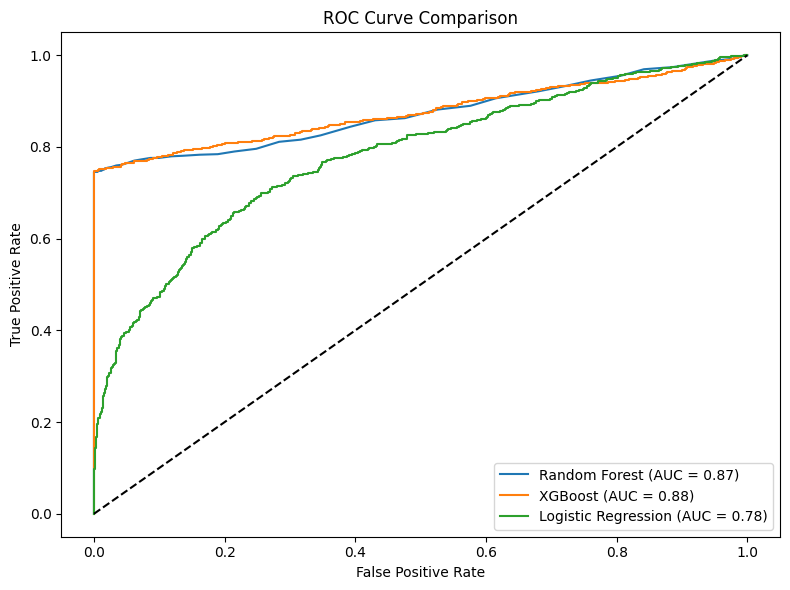

In [24]:
plt.figure(figsize=(8,6))
for model in results:
    fpr, tpr, _ = roc_curve(y_test, results[model]["y_proba"])
    auc_score = roc_auc_score(y_test, results[model]["y_proba"])
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc_score:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [25]:
!pip install lightgbm catboost imbalanced-learn


Stacking Classifier Metrics:
Accuracy: 0.8890995260663507
Precision: 0.9801169590643275
Recall: 0.7943127962085308
F1 Score: 0.8774869109947644
ROC AUC: 0.9075151052312392


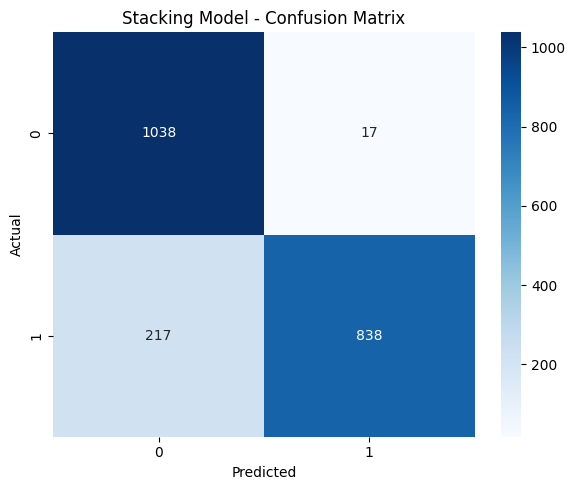

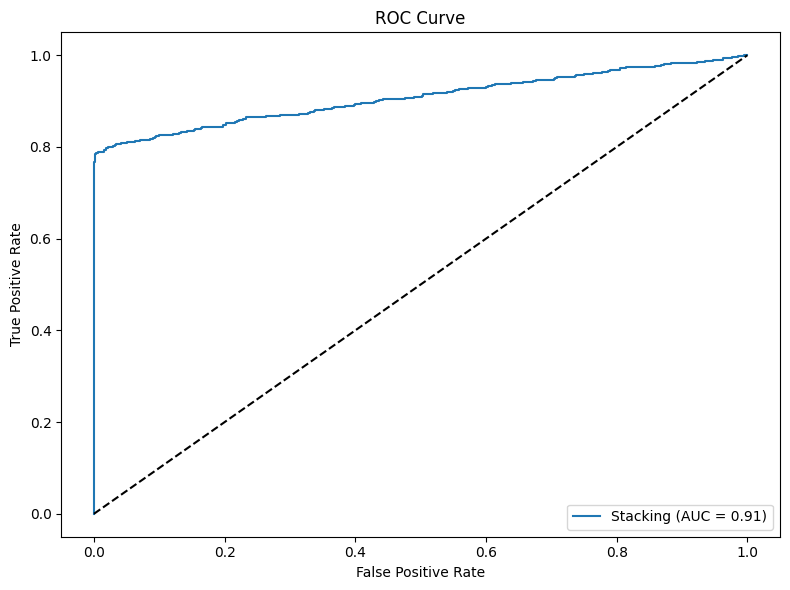

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Load Data
df = pd.read_csv("Cybersecurity Intrusion Detection.csv")
df.drop(columns=['session_id'], inplace=True)
df['encryption_used'].fillna('Unknown', inplace=True)

# Encode Categorical
le = LabelEncoder()
for col in ['protocol_type', 'encryption_used', 'browser_type']:
    df[col] = le.fit_transform(df[col])

# Split Features and Target
X = df.drop("attack_detected", axis=1)
y = df["attack_detected"]

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE for class balance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Define Base Models
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# Stacking Classifier
stack_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('cat', cat)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# Train
stack_model.fit(X_train, y_train)

# Predict
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Stacking Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Stacking (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
